ToDo:

1. Improve the code: from lists to nparrays
2. Understand how to deal with $\gamma$ in LV
3. Fill in some theory on Gillespie

In [1]:
#!python
%pylab inline

from numpy import *
from scipy import integrate

import random
import numpy as np
import pylab as pp
import math
import stochpy
from Gillespie import Gillespie 
from GillespieSetup import Setup

StochPyDir = "/Users/Vlad/Code/StochPy-2.3"

Populating the interactive namespace from numpy and matplotlib

#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #


# Reaction Diffusion

The classic deterministic description of the reaction diffusion problem is given by a system of ODEs:

$\frac{da}{dt} = -2k_1a^2-k_2ab+k_3 \\
\frac{db}{dt} = -k_2ab+k_4$

In code, we have:

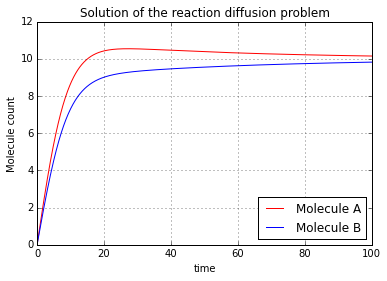

In [2]:
# Definition of parameters
k1 = 0.001
k2 = 0.01
k3 = 1.2
k4 = 1

def dX_dt(X, t=0):
    """ Return the growth rate the count of molecules A and B . """
    return array([ -2.0*k1*X[0]*X[0] -   k2*X[0]*X[1] + k3 ,
                   -k2*X[0]*X[1] + k4])

t = linspace(0, 100,  1000)  # time
X0 = array([0, 0])    # initials conditions: 0 count of molecules A and B
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'
moleculeA, moleculeB = X.T
f1 = pp.figure()
pp.plot(t, moleculeA, 'r-', label='Molecule A')
pp.plot(t, moleculeB, 'b-', label='Molecule B')
pp.grid()
pp.legend(loc='best')
pp.xlabel('time')
pp.ylabel('Molecule count')
pp.title('Solution of the reaction diffusion problem')

##Stochastic Formulation

If we were to use stochastic simulation to solve the problem above, the following system of four chemical equations would need to be introduced:

$A + A \xrightarrow{k_1} \emptyset$

$A + B \xrightarrow{k_2} \emptyset$

$\emptyset\xrightarrow{k_3}A$

$\emptyset\xrightarrow{k_4}B$

With corresponding propensity functions:


###StochPy implementation

StochPy uses PySCeS Model Description Language (MDL) to describe the simulated system.  Such descriptions are contained in ASCII text based input files with extention .psc.  One such file that would describe the Reaction diffusion system stated above would contain the following text:

The problem definition above can be interpreted as follows:
* if two molecules $X$ react, they both perish with rate $c1$
* if molecule $X$ reacts with $Y$, they both perish with rate $c2$
* Molecule $X$ is created with rate $c3$
* Molecule $Y$ is created with rate $c4$

This can be quantified in the following matrix of increments:

$
\left[\begin{smallmatrix}\Delta X\\\Delta Y\end{smallmatrix}\right]=
\left[\begin{smallmatrix}-2 & -1 & 1 & 0\\0 & -1 & 0 & 1\end{smallmatrix}\right]
$

where column values to increments in numbers corresponding to reaction that has occured and rows relate to the molecule count being updated.

*** WARNING ***: No regular grid is created yet. Use GetRegularGrid(n_samples) if averaged results are unsatisfactory (e.g. more or less 'samples')


<class stochpy.implementations.DirectMethod.DirectMethod at 0x108073460>

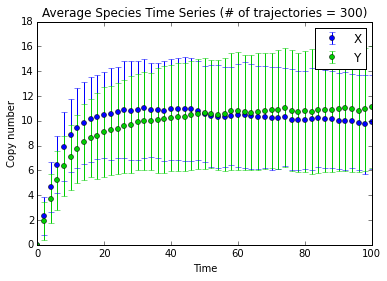

In [3]:
smod = stochpy.SSA()
smod.Model(model_file="ReactionDiffusion.psc",dir=StochPyDir)
smod.DoStochSim(trajectories = 300,mode="time",end=100)
smod.PlotAverageSpeciesTimeSeries()
smod.sim_method

### Implementation of Gillespie Algorithm:

In [4]:
import numpy as np
import numpy.random as nprandom

def generateR1():
    while True:
        r1 = nprandom.random(1000)
        logR1 = np.log(r1)*-1
        for r in logR1:
            yield r

def generateR2():
    while True:
        r2 = nprandom.random(1000)
        for r in r2:
            yield r
            
g1 = generateR1()
g2 = generateR2()

### Gillespie for Reaction Diffusion

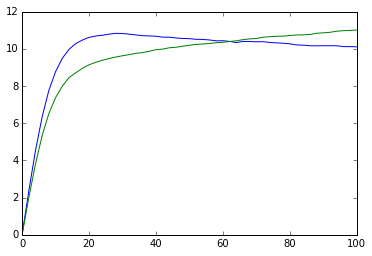

In [5]:
setup = Setup(yaml_file_name="reaction_diffusion.yaml")
propensities = setup.get_propensity_list()
parameters = setup.get_parameter_list()
species = setup.get_species()
incr = setup.get_increments()
nPaths = setup.get_number_of_paths()
T = setup.get_time_horizon()

rd_gillespie = Gillespie(a=species[0],b=species[1],propensities=propensities,increments=incr)
tau,aMean,bMean = rd_gillespie.run_simulation(nPaths=nPaths,parameters=parameters, T=T, gen1=g1, gen2=g2)
plt.plot(tau,aMean)
plt.plot(tau,bMean)
plt.show()

# Lotka Volterra

### Deterministic formulation

System of 1-st order, non-linear differential equations.

$\frac{dX}{dt}=\alpha X - \beta XY$

$\frac{dY}{dt}=-\delta Y +\gamma\beta XY$ 

The following example has been taken from :
http://scipy-cookbook.readthedocs.org/items/LoktaVolterraTutorial.html

The code below has been reparameterized w.r.t to the link above in the process of experimentation.

In [ ]:
from scipy import integrate

a = 2
b = 0.002
c = 1
d = 1

def dX_dt(X, t=0):
    """ Return the growth rate of fox and rabbit populations. """
    return array([ a*X[0] - b*X[0]*X[1] ,
                  -c*X[1] + b*d*X[0]*X[1] ])

t = linspace(0, 15,  1000)  # time
X0 = array([1000, 500])  # initials conditions: 1000 rabbits and 500 foxes
X, infodict = integrate.odeint(dX_dt, X0, t, full_output=True)
infodict['message']                     # >>> 'Integration successful.'
foxes,rabbits = X.T
f1 = pp.figure()
pp.plot(t, rabbits, 'r-', label='Rabbits')
pp.plot(t, foxes  , 'b-', label='Foxes')
pp.grid()
pp.legend(loc='best')
pp.xlabel('time')
pp.ylabel('population')
pp.title('Evolution of fox and rabbit populations')

### Stochastic Formulation

Rate equations:

Birth of rabbit:

$X \xrightarrow{c_1} X + 1$

Birth of owl after as a result of eating rabbit:

$X + Y \xrightarrow{c_2} Y + 1$

Death of predator

$Y \xrightarrow{c_3} \emptyset$ 

Rabbit is eaten by an owl:

$X + Y \xrightarrow{c_4} X - 1$

### StochPy Implementation

The closest i could come up to StochPy definition of the system above is the following:

Mapping from intuitive rate equation definition to PSC equivalent proved a bit less intuitive than for the reaction-diffusion counterpart.  

* if reaction $R1$ occurs, one mouse is born with rate $c1$
* when mouse meets an owl, the outcome is a birth of an owl at the expense of one mouse with rate $c2$
* one owl dies with absense of mice with rate $c3$

This maps to a Lotka Volterra system of differential equations when $\gamma=1$.  I haven't figured out how to modify the specification of LV system for $\gamma\ne1$.  

This can be quantified in the following matrix of increments:

$
\left[\begin{smallmatrix}\Delta X\\\Delta Y\end{smallmatrix}\right]=
\left[\begin{smallmatrix}1 & -1 & 0\\0 & 1 & 1\end{smallmatrix}\right]
$

This matrix is what the model builder in StochPy produces after parsing the stoichiometry expressions for reactions 1-4. The underlying logic is:

1.  Register reactants on the left side of $\gt$ sign as negative units
1.  Register reactants on the right side of $\gt$ sign as positive units
1.  Net the left side with the right side
1.  Count \$pool as $0$

In [ ]:
smod = stochpy.SSA()
smod.Model(model_file="LotkaVolterra.psc",dir=StochPyDir)
smod.DoStochSim(trajectories = 10,mode="time",end=15)
#smod.DoCompleteStochSim()
smod.PlotAverageSpeciesTimeSeries()
#smod.PlotSpeciesDistributions()
smod.sim_method

### Own Implementation

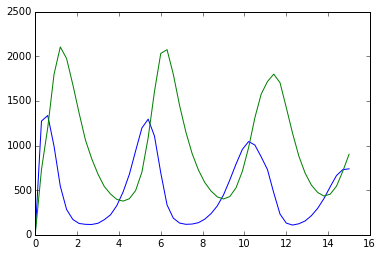

In [5]:
setup = Setup(yaml_file_name="lotka_volterra.yaml")
propensities = setup.get_propensity_list()
parameters = setup.get_parameter_list()
species = setup.get_species()
incr = setup.get_increments()
nPaths = setup.get_number_of_paths()
T = setup.get_time_horizon()

my_gillespie = Gillespie(a=species[0],b=species[1],propensities=propensities,increments=incr)
tau,aMean,bMean = my_gillespie.run_simulation(nPaths=10,parameters=parameters,T=15, gen1=g1, gen2=g2)
plt.plot(tau,aMean)
plt.plot(tau,bMean)
plt.show()